In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torch.utils.data as data
from torchsummary import summary
from tqdm import tqdm, trange
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader
from sklearn.model_selection import KFold
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import models

C:\Users\user\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\user\anaconda3\envs\pytorch\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
torch.set_num_threads(4)
torch.manual_seed(20)
pretrained_size = 224
pretrained_means =torch.tensor([0.5108, 0.4829, 0.3989])
pretrained_stds= torch.tensor([0.2632, 0.2587, 0.2706])

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomCrop(192),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(192),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                       ])

In [3]:
BATCH_SIZE = 64
num_epochs=40
learning_rate = 0.001

In [4]:
# #os.mkdir('animal10/train')
# for img_class in os.listdir("raw-img"):
#     os.mkdir('./animal10/train/' + img_class + '/')
#     #os.mkdir('./animal10/test/')
# for img_class in os.listdir("raw-img"):
#     os.mkdir('./animal10/test/' + img_class + '/')

In [5]:
# for img_class in tqdm(os.listdir('animal10/train/')):
#     img_ls = os.listdir('raw-img/' + img_class)
#     for img in img_ls[:int(len(img_ls) * 0.8)]:

#         shutil.copy('raw-img/' + img_class + '/' + img, 
#                     'animal10/train/' + img_class + '/' + img)
# # form test dataset
# for img_class in tqdm(os.listdir('animal10/test/')):
#     img_ls = os.listdir('raw-img/' + img_class)
#     for img in img_ls[int(len(img_ls) * 0.8):]:

#         shutil.copy('raw-img/' + img_class + '/' + img, 
#                     'animal10/test/' + img_class + '/' + img)

In [6]:
train_data_path = "animal10/train"
test_data_path = "animal10/test/"

In [7]:

# transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
train_data = dset.ImageFolder(root = train_data_path, 
                                  transform = train_transforms)

test_data = dset.ImageFolder(root = test_data_path, 
                                 transform = test_transforms)
# n_train_examples = int(len(train_data) * 0.8)
# n_valid_examples = int(len(train_data)*0.2)

# train_data, valid_data =  data.random_split(train_data, 
#                                            [n_train_examples, n_valid_examples])


# trainset = torchvision.datasets.MNIST(root='./data', train=True,
#                                         download=True, transform=transform)
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
#                                           shuffle=True, num_workers=0)
# val_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE,
#                                           shuffle=True, num_workers=0)
## download and load testing dataset
# testset = torchvision.datasets.MNIST(root='./data', train=False,
#                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=0)

In [8]:
# import matplotlib.pyplot as plt
# import numpy as np

# ## functions to show an image
# def imshow(img):
#     #img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))

# ## get some random training images
# dataiter = next(iter(trainloader))
# images, labels = dataiter

# ## show images
# imshow(torchvision.utils.make_grid(images))

In [9]:
# for images, labels in trainloader:
#     print("Image batch dimensions:", images.shape)
#     print("Image label dimensions:", labels.shape)
#     break

In [10]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolution 1 , input_shape=(3,224,224)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=0) #output_shape=(16,220,220) #(224-5+1)/1 #(weigh-kernel+1)/stride 無條件進位
        self.BatchNorm2d_1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU() # activation
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,110,110) #(220/2)
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=5, stride=1, padding=0) #output_shape=(32,106,106)
        self.BatchNorm2d_2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU() # activation
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #output_shape=(32,53,53)
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=0) #output_shape=(16,51,51)
        self.BatchNorm2d_3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU() # activation
        # Max pool 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,25,25)
        # Convolution 4
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=0) #output_shape=(8,23,23)
        self.BatchNorm2d_4 = nn.BatchNorm2d(32)
        self.relu4 = nn.ReLU() # activation
        # Max pool 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) #output_shape=(8,11,11)
        # Fully connected 1 ,#input_shape=(8*12*12)
        self.fc1 = nn.Linear(32 * 11 * 11, 256) 
        self.relu5 = nn.ReLU() # activation
        self.dropout1=nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(256, 10) 
        self.dropout2=nn.Dropout(p=0.4)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.cnn1(x) # Convolution 1
        out = self.BatchNorm2d_1(out)
        out = self.relu1(out)
        out = self.maxpool1(out)# Max pool 1
        out = self.cnn2(out) # Convolution 2
        out = self.BatchNorm2d_2(out)
        out = self.relu2(out) 
        out = self.maxpool2(out) # Max pool 2
        out = self.cnn3(out) # Convolution 3
        out = self.BatchNorm2d_3(out)
        out = self.relu3(out)
        out = self.maxpool3(out) # Max pool 3
        out = self.cnn4(out) # Convolution 4
        out = self.BatchNorm2d_4(out)
        out = self.relu4(out)
        out = self.maxpool4(out) # Max pool 4
        out = out.view(out.size(0), -1) # last CNN faltten con. Linear NN
        out = self.fc1(out) # Linear function (readout)
        # out = self.dropout1(out)
        out = self.fc2(out)
        # out = self.dropout2(out)
        out = self.output(out)
        return out

In [11]:
class MyCustomResnet18(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        #特別注意的是，這個resnet18的變數，並不一定要是官方預訓練的模型
        #也可以是自定義的神經網路架構，增加了使用上的彈性
        self.res_18_model = torchvision.models.resnet18(weights=True)
        # self.num_fc_ftr = self.res_18_model.fc.in_features #获取到fc层的输入
        # self.res_18_model.fc = nn.Linear(self.num_fc_ftr, 10)
        # for param in self.model.parameters():
        #     param.requires_grad = False
        # self.dropout1=nn.Dropout(p=0.1)
        # self.model.fc0 = nn.Linear(512, 256)
        # self.model.fc1 = nn.Linear(256, 10)
        # self.BatchNorm2d_1 = nn.BatchNorm1d(256)
        self.features = nn.ModuleList( self.res_18_model.children())[:-1]
        self.features = nn.Sequential(*self.features)
        # self.in_features = resnet18.fc.in_features
        self.fc0 = nn.Linear(self.res_18_model.fc.in_features, 10)
        self.dropout1=nn.Dropout(p=0.2)
        self.fc0_bn = nn.BatchNorm1d(10, eps = 1e-2)
        # self.fc1 = nn.Linear(256, 10)
        # self.fc1_bn = nn.BatchNorm1d(10, eps = 1e-2)
    def forward(self, input_imgs):
        #如果使用自定義神經網路架構時，要注意nn.Sequential搭配
        #nn.ModuleList後，可能會因為定義之架構屬多段組合而成之網路
        #多了一層額外的Sequential架構造成圖片送入網路時dim錯誤，因此可以改用:
        #out = self.features[0](x)
        #out = self.features[1](x)
        #的方式來解決。
        # output = self.features(input_imgs)
        output = self.model(input_imgs)
        output = output.view(input_imgs.size(0), -1)
        # output = self.dropout1(output)
        output = self.fc0_bn(F.relu(self.fc0(output)))
        # output = self.BatchNorm2d_1(output)
        # output = self.fc1_bn(F.relu(self.fc1(output)))
        
        
        # output = self.dropout1(output)
        return output
    

In [12]:
res_18_model = models.resnet18(pretrained=True)
num_fc_ftr = res_18_model.fc.in_features #获取到fc层的输入
res_18_model.fc = nn.Linear(num_fc_ftr, 10)
model=res_18_model
# if(torch.cuda.is_available()==True):
#     model=res_18_model.cuda()
# for layer in list(model.parameters())[:41]:
#     layer.requires_grad=False
# optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
# criterion=nn.CrossEntropyLoss()

C:\Users\user\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = MyCustomResnet18()
model = model.to(device)
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
summary(model, (3, 224, 224))
# print(model)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]          --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]          --
|

In [14]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [15]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [16]:
def train(dataloader, model, loss_fn, optimizer):
    epoch_acc=0.0
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # Sets the model in training mode.
    epoch_loss, epoch_correct = 0, 0

    for batch_i, (images, labels) in tqdm(enumerate(dataloader)):
        images, labels = images.to(device), labels.to(device) # move data to GPU

        # Compute prediction loss
        pred = model(images)
        loss = criterion(pred, labels)

        # Optimization by gradients
        optimizer.zero_grad() # set prevision gradient to 0
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        #epoch_loss += loss.item()
        epoch_loss += loss.detach().item()
        # epoch_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        epoch_correct +=(torch.max(pred, 1)[1].view(labels.size()).data == labels.data).sum()
        epoch_acc += get_accuracy(pred, labels, BATCH_SIZE)
    
    
    return epoch_loss/num_batches,epoch_acc/len(dataloader)

In [17]:
def test(dataloader, model, loss_fn):
    epoch_acc=0.0
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # Sets the model in test mode.
    epoch_loss, epoch_correct = 0, 0

    # No training for test data
    with torch.no_grad():
        for batch_i, (images, labels) in tqdm(enumerate(dataloader)):
            images, labels = images.to(device), labels.to(device)

            pred = model(images)
            loss = criterion(pred, labels)
            
            #epoch_loss += loss.item()
            epoch_loss += loss.item()
            # epoch_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            epoch_correct+=(torch.max(pred, 1)[1].view(labels.size()).data == labels.data).sum()
            epoch_acc += get_accuracy(pred, labels, BATCH_SIZE)
    return epoch_loss/num_batches, epoch_acc/len(dataloader)

In [18]:
# define draw
def plotCurve(x_vals, y_vals, 
                x_label, y_label, 
                x2_vals=None, y2_vals=None, 
                legend=None,
                figsize=(3.5, 2.5)):
    # set figsize
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x_vals, y_vals)
    # plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        # plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.plot(x_vals, y2_vals)
    if legend:
        plt.legend(legend)
    plt.show()

Fold 1
train size: 16750, val size: 4188


262it [00:23, 11.32it/s]
66it [00:05, 11.42it/s]


Epoch:1/40  Training Loss:2.183 || Training Acc 23.408 % ||  valid Loss:2.123 ||  valid Acc 25.639 %


262it [00:23, 11.25it/s]
66it [00:05, 11.69it/s]


Epoch:2/40  Training Loss:2.028 || Training Acc 28.578 % ||  valid Loss:1.917 ||  valid Acc 33.830 %


262it [00:22, 11.50it/s]
66it [00:05, 11.57it/s]


Epoch:3/40  Training Loss:1.778 || Training Acc 38.120 % ||  valid Loss:1.743 ||  valid Acc 39.465 %


262it [00:22, 11.41it/s]
66it [00:05, 11.54it/s]


Epoch:4/40  Training Loss:1.483 || Training Acc 49.028 % ||  valid Loss:1.722 ||  valid Acc 41.832 %


262it [00:22, 11.49it/s]
66it [00:05, 11.46it/s]


Epoch:5/40  Training Loss:1.328 || Training Acc 54.431 % ||  valid Loss:1.390 ||  valid Acc 52.462 %


262it [00:23, 11.32it/s]
66it [00:05, 11.47it/s]


Epoch:6/40  Training Loss:1.189 || Training Acc 59.166 % ||  valid Loss:1.344 ||  valid Acc 54.285 %


262it [00:23, 11.34it/s]
66it [00:05, 11.54it/s]


Epoch:7/40  Training Loss:1.077 || Training Acc 63.156 % ||  valid Loss:1.303 ||  valid Acc 54.522 %


262it [00:22, 11.45it/s]
66it [00:05, 11.60it/s]


Epoch:8/40  Training Loss:0.989 || Training Acc 66.388 % ||  valid Loss:1.173 ||  valid Acc 59.683 %


262it [00:22, 11.45it/s]
66it [00:05, 11.54it/s]


Epoch:9/40  Training Loss:0.901 || Training Acc 69.257 % ||  valid Loss:0.961 ||  valid Acc 66.974 %


262it [00:23, 11.36it/s]
66it [00:05, 11.57it/s]


Epoch:10/40  Training Loss:0.810 || Training Acc 72.465 % ||  valid Loss:0.994 ||  valid Acc 65.483 %


262it [00:23, 11.07it/s]
66it [00:05, 11.51it/s]


Epoch:11/40  Training Loss:0.754 || Training Acc 74.255 % ||  valid Loss:0.859 ||  valid Acc 70.881 %


262it [00:22, 11.43it/s]
66it [00:05, 11.61it/s]


Epoch:12/40  Training Loss:0.699 || Training Acc 76.473 % ||  valid Loss:0.802 ||  valid Acc 73.580 %


262it [00:23, 11.29it/s]
66it [00:05, 11.56it/s]


Epoch:13/40  Training Loss:0.644 || Training Acc 78.000 % ||  valid Loss:0.745 ||  valid Acc 74.645 %


262it [00:23, 11.32it/s]
66it [00:05, 11.59it/s]


Epoch:14/40  Training Loss:0.597 || Training Acc 79.598 % ||  valid Loss:1.040 ||  valid Acc 66.903 %


262it [00:22, 11.46it/s]
66it [00:05, 11.52it/s]


Epoch:15/40  Training Loss:0.546 || Training Acc 81.542 % ||  valid Loss:0.635 ||  valid Acc 77.723 %


262it [00:22, 11.41it/s]
66it [00:05, 11.54it/s]


Epoch:16/40  Training Loss:0.509 || Training Acc 82.968 % ||  valid Loss:0.745 ||  valid Acc 75.308 %


262it [00:22, 11.42it/s]
66it [00:05, 11.69it/s]


Epoch:17/40  Training Loss:0.480 || Training Acc 84.059 % ||  valid Loss:0.674 ||  valid Acc 77.320 %


262it [00:23, 11.31it/s]
66it [00:05, 11.48it/s]


Epoch:18/40  Training Loss:0.443 || Training Acc 84.953 % ||  valid Loss:0.653 ||  valid Acc 77.628 %


262it [00:22, 11.44it/s]
66it [00:05, 11.43it/s]


Epoch:19/40  Training Loss:0.421 || Training Acc 85.997 % ||  valid Loss:0.635 ||  valid Acc 79.545 %


262it [00:22, 11.48it/s]
66it [00:05, 11.55it/s]


Epoch:20/40  Training Loss:0.396 || Training Acc 86.444 % ||  valid Loss:0.624 ||  valid Acc 79.640 %


262it [00:23, 11.39it/s]
66it [00:05, 11.47it/s]


Epoch:21/40  Training Loss:0.381 || Training Acc 86.862 % ||  valid Loss:0.588 ||  valid Acc 79.830 %


262it [00:23, 11.36it/s]
66it [00:05, 11.60it/s]


Epoch:22/40  Training Loss:0.358 || Training Acc 87.846 % ||  valid Loss:0.575 ||  valid Acc 81.132 %


262it [00:23, 11.34it/s]
66it [00:05, 11.46it/s]


Epoch:23/40  Training Loss:0.340 || Training Acc 88.621 % ||  valid Loss:0.674 ||  valid Acc 78.717 %


262it [00:23, 11.36it/s]
66it [00:06, 10.83it/s]


Epoch:24/40  Training Loss:0.311 || Training Acc 89.438 % ||  valid Loss:0.558 ||  valid Acc 82.694 %


262it [00:23, 11.14it/s]
66it [00:05, 11.36it/s]


Epoch:25/40  Training Loss:0.295 || Training Acc 89.796 % ||  valid Loss:0.593 ||  valid Acc 80.279 %


262it [00:23, 11.25it/s]
66it [00:05, 11.56it/s]


Epoch:26/40  Training Loss:0.291 || Training Acc 90.333 % ||  valid Loss:0.534 ||  valid Acc 82.765 %


262it [00:23, 11.33it/s]
66it [00:05, 11.57it/s]


Epoch:27/40  Training Loss:0.272 || Training Acc 90.780 % ||  valid Loss:0.617 ||  valid Acc 81.439 %


262it [00:23, 11.11it/s]
66it [00:05, 11.51it/s]


Epoch:28/40  Training Loss:0.259 || Training Acc 91.084 % ||  valid Loss:0.576 ||  valid Acc 82.765 %


262it [00:23, 11.39it/s]
66it [00:05, 11.60it/s]


Epoch:29/40  Training Loss:0.249 || Training Acc 91.448 % ||  valid Loss:0.603 ||  valid Acc 82.505 %


262it [00:23, 11.34it/s]
66it [00:05, 11.55it/s]


Epoch:30/40  Training Loss:0.233 || Training Acc 92.217 % ||  valid Loss:0.602 ||  valid Acc 81.250 %


262it [00:23, 11.33it/s]
66it [00:05, 11.61it/s]


Epoch:31/40  Training Loss:0.219 || Training Acc 92.414 % ||  valid Loss:0.516 ||  valid Acc 83.617 %


262it [00:23, 11.32it/s]
66it [00:05, 11.54it/s]


Epoch:32/40  Training Loss:0.223 || Training Acc 92.223 % ||  valid Loss:0.565 ||  valid Acc 82.694 %


262it [00:23, 11.37it/s]
66it [00:05, 11.56it/s]


Epoch:33/40  Training Loss:0.208 || Training Acc 92.909 % ||  valid Loss:0.689 ||  valid Acc 81.889 %


262it [00:22, 11.40it/s]
66it [00:05, 11.51it/s]


Epoch:34/40  Training Loss:0.201 || Training Acc 93.237 % ||  valid Loss:0.602 ||  valid Acc 82.741 %


262it [00:22, 11.42it/s]
66it [00:05, 11.55it/s]


Epoch:35/40  Training Loss:0.179 || Training Acc 93.881 % ||  valid Loss:0.680 ||  valid Acc 80.469 %


262it [00:22, 11.48it/s]
66it [00:05, 11.65it/s]


Epoch:36/40  Training Loss:0.189 || Training Acc 93.672 % ||  valid Loss:0.521 ||  valid Acc 84.920 %


262it [00:24, 10.89it/s]
66it [00:05, 11.58it/s]


Epoch:37/40  Training Loss:0.176 || Training Acc 93.869 % ||  valid Loss:0.640 ||  valid Acc 81.203 %


262it [00:23, 11.31it/s]
66it [00:05, 11.42it/s]


Epoch:38/40  Training Loss:0.172 || Training Acc 93.929 % ||  valid Loss:0.549 ||  valid Acc 83.878 %


262it [00:23, 11.39it/s]
66it [00:05, 11.42it/s]


Epoch:39/40  Training Loss:0.155 || Training Acc 94.704 % ||  valid Loss:0.644 ||  valid Acc 83.168 %


262it [00:23, 11.29it/s]
66it [00:05, 11.51it/s]


Epoch:40/40  Training Loss:0.159 || Training Acc 94.543 % ||  valid Loss:0.615 ||  valid Acc 83.073 %
Fold 1
avg train loss: 0.603, avg train acc: 79.302
avg valid loss: 0.851, avg valid acc: 72.209


82it [00:20,  3.94it/s]


Fold 1, test acc: 85.137
plot curves


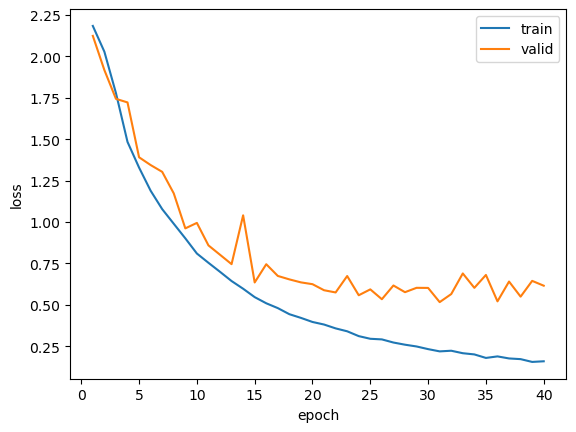

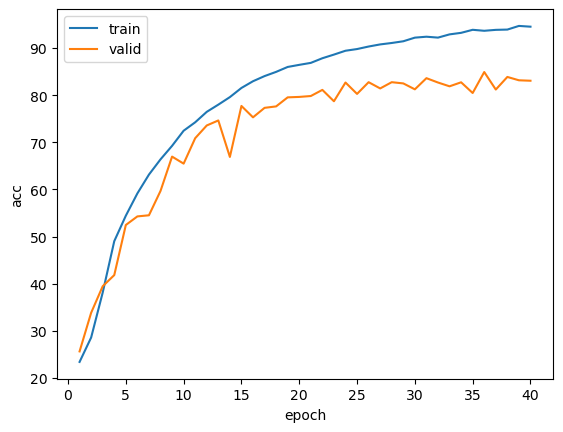

Fold 2
train size: 16750, val size: 4188


262it [00:23, 11.22it/s]
66it [00:05, 11.38it/s]


Epoch:1/40  Training Loss:2.246 || Training Acc 19.221 % ||  valid Loss:2.180 ||  valid Acc 22.254 %


262it [00:22, 11.40it/s]
66it [00:05, 11.23it/s]


Epoch:2/40  Training Loss:2.080 || Training Acc 25.394 % ||  valid Loss:2.066 ||  valid Acc 27.249 %


262it [00:23, 11.34it/s]
66it [00:05, 11.26it/s]


Epoch:3/40  Training Loss:1.842 || Training Acc 34.464 % ||  valid Loss:1.904 ||  valid Acc 33.262 %


262it [00:23, 11.27it/s]
66it [00:05, 11.21it/s]


Epoch:4/40  Training Loss:1.633 || Training Acc 42.963 % ||  valid Loss:1.658 ||  valid Acc 44.034 %


262it [00:23, 11.28it/s]
66it [00:06, 11.00it/s]


Epoch:5/40  Training Loss:1.437 || Training Acc 49.821 % ||  valid Loss:1.991 ||  valid Acc 37.098 %


262it [00:23, 11.34it/s]
66it [00:06, 10.88it/s]


Epoch:6/40  Training Loss:1.276 || Training Acc 55.552 % ||  valid Loss:1.933 ||  valid Acc 38.234 %


262it [00:23, 11.31it/s]
66it [00:05, 11.34it/s]


Epoch:7/40  Training Loss:1.192 || Training Acc 58.266 % ||  valid Loss:1.293 ||  valid Acc 55.327 %


262it [00:22, 11.41it/s]
66it [00:06, 10.95it/s]


Epoch:8/40  Training Loss:1.107 || Training Acc 61.617 % ||  valid Loss:1.267 ||  valid Acc 56.061 %


262it [00:23, 11.11it/s]
66it [00:05, 11.22it/s]


Epoch:9/40  Training Loss:1.041 || Training Acc 63.824 % ||  valid Loss:1.116 ||  valid Acc 61.671 %


262it [00:22, 11.53it/s]
66it [00:05, 11.22it/s]


Epoch:10/40  Training Loss:0.990 || Training Acc 65.971 % ||  valid Loss:1.241 ||  valid Acc 58.168 %


262it [00:23, 11.35it/s]
66it [00:05, 11.27it/s]


Epoch:11/40  Training Loss:0.929 || Training Acc 67.921 % ||  valid Loss:1.026 ||  valid Acc 64.749 %


262it [00:23, 11.27it/s]
66it [00:05, 11.37it/s]


Epoch:12/40  Training Loss:0.879 || Training Acc 69.841 % ||  valid Loss:1.258 ||  valid Acc 59.493 %


262it [00:23, 11.29it/s]
66it [00:06, 10.88it/s]


Epoch:13/40  Training Loss:0.811 || Training Acc 72.275 % ||  valid Loss:1.032 ||  valid Acc 65.459 %


262it [00:23, 11.27it/s]
66it [00:06, 10.79it/s]


Epoch:14/40  Training Loss:0.773 || Training Acc 73.938 % ||  valid Loss:0.924 ||  valid Acc 68.632 %


262it [00:23, 11.29it/s]
66it [00:05, 11.23it/s]


Epoch:15/40  Training Loss:0.720 || Training Acc 75.656 % ||  valid Loss:0.874 ||  valid Acc 70.526 %


262it [00:23, 11.34it/s]
66it [00:06, 10.90it/s]


Epoch:16/40  Training Loss:0.678 || Training Acc 76.694 % ||  valid Loss:0.812 ||  valid Acc 72.940 %


262it [00:23, 11.37it/s]
66it [00:06, 10.99it/s]


Epoch:17/40  Training Loss:0.640 || Training Acc 78.149 % ||  valid Loss:0.872 ||  valid Acc 70.336 %


262it [00:23, 11.27it/s]
66it [00:05, 11.13it/s]


Epoch:18/40  Training Loss:0.611 || Training Acc 79.151 % ||  valid Loss:0.753 ||  valid Acc 75.071 %


262it [00:23, 11.15it/s]
66it [00:06, 10.94it/s]


Epoch:19/40  Training Loss:0.569 || Training Acc 80.904 % ||  valid Loss:0.729 ||  valid Acc 75.284 %


262it [00:23, 10.98it/s]
66it [00:05, 11.07it/s]


Epoch:20/40  Training Loss:0.552 || Training Acc 81.316 % ||  valid Loss:0.793 ||  valid Acc 74.408 %


262it [00:23, 11.17it/s]
66it [00:05, 11.27it/s]


Epoch:21/40  Training Loss:0.510 || Training Acc 82.807 % ||  valid Loss:0.716 ||  valid Acc 76.989 %


262it [00:24, 10.88it/s]
66it [00:06, 10.87it/s]


Epoch:22/40  Training Loss:0.486 || Training Acc 83.498 % ||  valid Loss:0.742 ||  valid Acc 76.113 %


262it [00:23, 11.38it/s]
66it [00:05, 11.16it/s]


Epoch:23/40  Training Loss:0.482 || Training Acc 83.600 % ||  valid Loss:0.738 ||  valid Acc 76.894 %


262it [00:23, 11.24it/s]
66it [00:05, 11.06it/s]


Epoch:24/40  Training Loss:0.448 || Training Acc 84.608 % ||  valid Loss:0.633 ||  valid Acc 78.598 %


262it [00:23, 11.16it/s]
66it [00:05, 11.17it/s]


Epoch:25/40  Training Loss:0.422 || Training Acc 85.472 % ||  valid Loss:0.784 ||  valid Acc 75.639 %


262it [00:23, 11.24it/s]
66it [00:06, 10.86it/s]


Epoch:26/40  Training Loss:0.418 || Training Acc 85.860 % ||  valid Loss:0.646 ||  valid Acc 79.853 %


262it [00:23, 11.23it/s]
66it [00:06, 10.77it/s]


Epoch:27/40  Training Loss:0.392 || Training Acc 86.599 % ||  valid Loss:0.627 ||  valid Acc 79.972 %


262it [00:23, 11.11it/s]
66it [00:05, 11.17it/s]


Epoch:28/40  Training Loss:0.384 || Training Acc 86.951 % ||  valid Loss:0.659 ||  valid Acc 79.261 %


262it [00:23, 11.25it/s]
66it [00:05, 11.26it/s]


Epoch:29/40  Training Loss:0.361 || Training Acc 87.572 % ||  valid Loss:0.676 ||  valid Acc 78.267 %


262it [00:22, 11.55it/s]
66it [00:05, 11.25it/s]


Epoch:30/40  Training Loss:0.344 || Training Acc 88.627 % ||  valid Loss:0.614 ||  valid Acc 81.818 %


262it [00:23, 11.22it/s]
66it [00:06, 10.90it/s]


Epoch:31/40  Training Loss:0.341 || Training Acc 88.365 % ||  valid Loss:0.689 ||  valid Acc 79.522 %


262it [00:23, 11.20it/s]
66it [00:05, 11.06it/s]


Epoch:32/40  Training Loss:0.316 || Training Acc 89.140 % ||  valid Loss:0.572 ||  valid Acc 82.576 %


262it [00:23, 11.32it/s]
66it [00:05, 11.12it/s]


Epoch:33/40  Training Loss:0.306 || Training Acc 89.528 % ||  valid Loss:0.708 ||  valid Acc 78.220 %


262it [00:22, 11.44it/s]
66it [00:06, 10.90it/s]


Epoch:34/40  Training Loss:0.294 || Training Acc 89.891 % ||  valid Loss:0.581 ||  valid Acc 82.173 %


262it [00:22, 11.40it/s]
66it [00:06, 10.83it/s]


Epoch:35/40  Training Loss:0.283 || Training Acc 90.196 % ||  valid Loss:0.580 ||  valid Acc 82.244 %


262it [00:23, 11.38it/s]
66it [00:05, 11.38it/s]


Epoch:36/40  Training Loss:0.273 || Training Acc 90.732 % ||  valid Loss:0.714 ||  valid Acc 78.812 %


262it [00:23, 11.33it/s]
66it [00:06, 10.97it/s]


Epoch:37/40  Training Loss:0.256 || Training Acc 91.078 % ||  valid Loss:0.677 ||  valid Acc 80.161 %


262it [00:23, 11.37it/s]
66it [00:05, 11.12it/s]


Epoch:38/40  Training Loss:0.262 || Training Acc 90.864 % ||  valid Loss:0.658 ||  valid Acc 81.061 %


262it [00:23, 11.35it/s]
66it [00:05, 11.38it/s]


Epoch:39/40  Training Loss:0.249 || Training Acc 91.543 % ||  valid Loss:0.741 ||  valid Acc 79.096 %


262it [00:23, 11.37it/s]
66it [00:06, 10.93it/s]


Epoch:40/40  Training Loss:0.239 || Training Acc 91.710 % ||  valid Loss:0.666 ||  valid Acc 80.587 %
Fold 2
avg train loss: 0.727, avg train acc: 74.789
avg valid loss: 0.979, avg valid acc: 67.953


82it [00:21,  3.88it/s]


Fold 2, test acc: 83.594
plot curves


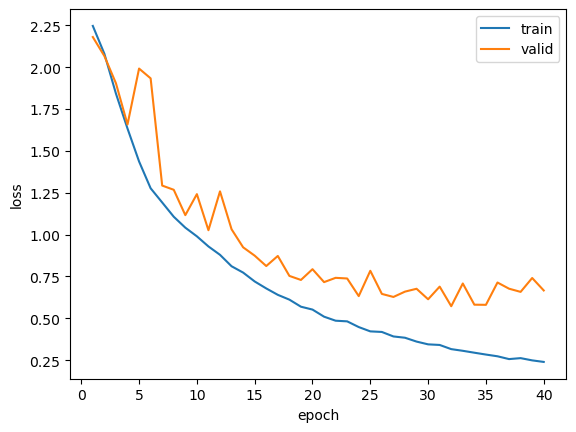

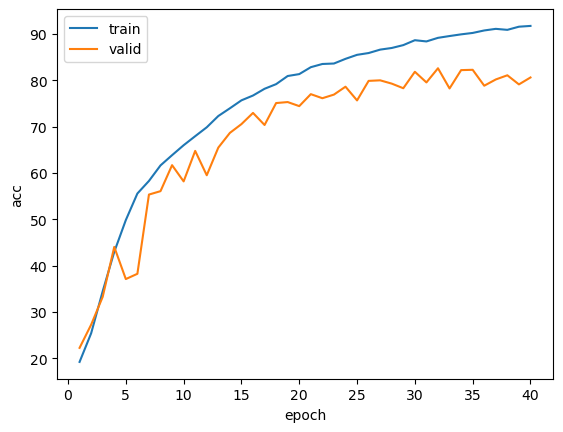

Fold 3
train size: 16750, val size: 4188


262it [00:23, 11.34it/s]
66it [00:06, 10.66it/s]


Epoch:1/40  Training Loss:2.257 || Training Acc 18.625 % ||  valid Loss:2.245 ||  valid Acc 18.916 %


262it [00:23, 11.25it/s]
66it [00:05, 11.32it/s]


Epoch:2/40  Training Loss:2.119 || Training Acc 22.895 % ||  valid Loss:1.994 ||  valid Acc 27.865 %


262it [00:23, 11.35it/s]
66it [00:05, 11.14it/s]


Epoch:3/40  Training Loss:1.905 || Training Acc 31.846 % ||  valid Loss:1.886 ||  valid Acc 31.203 %


262it [00:23, 11.32it/s]
66it [00:05, 11.27it/s]


Epoch:4/40  Training Loss:1.661 || Training Acc 41.663 % ||  valid Loss:1.581 ||  valid Acc 43.868 %


262it [00:23, 11.33it/s]
66it [00:05, 11.23it/s]


Epoch:5/40  Training Loss:1.438 || Training Acc 50.525 % ||  valid Loss:1.551 ||  valid Acc 46.141 %


262it [00:23, 11.26it/s]
66it [00:05, 11.16it/s]


Epoch:6/40  Training Loss:1.285 || Training Acc 55.534 % ||  valid Loss:1.303 ||  valid Acc 54.522 %


262it [00:22, 11.41it/s]
66it [00:05, 11.45it/s]


Epoch:7/40  Training Loss:1.184 || Training Acc 59.166 % ||  valid Loss:1.309 ||  valid Acc 55.137 %


262it [00:23, 11.38it/s]
66it [00:05, 11.16it/s]


Epoch:8/40  Training Loss:1.107 || Training Acc 61.838 % ||  valid Loss:1.144 ||  valid Acc 60.156 %


262it [00:23, 11.34it/s]
66it [00:05, 11.40it/s]


Epoch:9/40  Training Loss:1.021 || Training Acc 64.909 % ||  valid Loss:1.130 ||  valid Acc 61.080 %


262it [00:23, 11.35it/s]
66it [00:05, 11.48it/s]


Epoch:10/40  Training Loss:0.967 || Training Acc 66.698 % ||  valid Loss:0.971 ||  valid Acc 65.649 %


262it [00:22, 11.44it/s]
66it [00:05, 11.29it/s]


Epoch:11/40  Training Loss:0.891 || Training Acc 69.984 % ||  valid Loss:0.910 ||  valid Acc 68.466 %


262it [00:23, 11.32it/s]
66it [00:05, 11.11it/s]


Epoch:12/40  Training Loss:0.839 || Training Acc 71.511 % ||  valid Loss:1.022 ||  valid Acc 64.702 %


262it [00:22, 11.54it/s]
66it [00:05, 11.44it/s]


Epoch:13/40  Training Loss:0.780 || Training Acc 73.527 % ||  valid Loss:0.973 ||  valid Acc 66.809 %


262it [00:22, 11.40it/s]
66it [00:05, 11.27it/s]


Epoch:14/40  Training Loss:0.725 || Training Acc 75.477 % ||  valid Loss:0.964 ||  valid Acc 67.803 %


262it [00:22, 11.52it/s]
66it [00:05, 11.41it/s]


Epoch:15/40  Training Loss:0.677 || Training Acc 77.087 % ||  valid Loss:0.874 ||  valid Acc 69.792 %


262it [00:22, 11.48it/s]
66it [00:05, 11.35it/s]


Epoch:16/40  Training Loss:0.634 || Training Acc 78.471 % ||  valid Loss:0.804 ||  valid Acc 73.366 %


262it [00:23, 11.08it/s]
66it [00:05, 11.31it/s]


Epoch:17/40  Training Loss:0.603 || Training Acc 79.753 % ||  valid Loss:0.991 ||  valid Acc 68.821 %


262it [00:22, 11.41it/s]
66it [00:05, 11.20it/s]


Epoch:18/40  Training Loss:0.554 || Training Acc 81.411 % ||  valid Loss:0.859 ||  valid Acc 71.875 %


262it [00:22, 11.42it/s]
66it [00:05, 11.40it/s]


Epoch:19/40  Training Loss:0.528 || Training Acc 82.359 % ||  valid Loss:0.684 ||  valid Acc 76.918 %


262it [00:22, 11.48it/s]
66it [00:05, 11.37it/s]


Epoch:20/40  Training Loss:0.493 || Training Acc 83.445 % ||  valid Loss:0.894 ||  valid Acc 72.135 %


262it [00:23, 11.39it/s]
66it [00:05, 11.34it/s]


Epoch:21/40  Training Loss:0.477 || Training Acc 83.928 % ||  valid Loss:0.723 ||  valid Acc 76.089 %


262it [00:22, 11.59it/s]
66it [00:05, 11.07it/s]


Epoch:22/40  Training Loss:0.458 || Training Acc 84.602 % ||  valid Loss:0.663 ||  valid Acc 78.693 %


262it [00:23, 11.27it/s]
66it [00:05, 11.23it/s]


Epoch:23/40  Training Loss:0.434 || Training Acc 85.299 % ||  valid Loss:0.732 ||  valid Acc 76.231 %


262it [00:22, 11.42it/s]
66it [00:05, 11.41it/s]


Epoch:24/40  Training Loss:0.418 || Training Acc 86.289 % ||  valid Loss:0.698 ||  valid Acc 76.965 %


262it [00:23, 11.39it/s]
66it [00:05, 11.43it/s]


Epoch:25/40  Training Loss:0.399 || Training Acc 86.599 % ||  valid Loss:0.569 ||  valid Acc 81.321 %


262it [00:23, 11.39it/s]
66it [00:05, 11.09it/s]


Epoch:26/40  Training Loss:0.382 || Training Acc 86.910 % ||  valid Loss:0.608 ||  valid Acc 80.682 %


262it [00:22, 11.44it/s]
66it [00:05, 11.46it/s]


Epoch:27/40  Training Loss:0.362 || Training Acc 87.816 % ||  valid Loss:0.605 ||  valid Acc 80.492 %


262it [00:22, 11.40it/s]
66it [00:05, 11.49it/s]


Epoch:28/40  Training Loss:0.354 || Training Acc 88.061 % ||  valid Loss:0.590 ||  valid Acc 81.321 %


262it [00:23, 11.38it/s]
66it [00:05, 11.30it/s]


Epoch:29/40  Training Loss:0.337 || Training Acc 88.550 % ||  valid Loss:0.586 ||  valid Acc 81.179 %


262it [00:22, 11.47it/s]
66it [00:05, 11.07it/s]


Epoch:30/40  Training Loss:0.324 || Training Acc 89.027 % ||  valid Loss:0.584 ||  valid Acc 80.729 %


262it [00:23, 11.25it/s]
66it [00:05, 11.22it/s]


Epoch:31/40  Training Loss:0.305 || Training Acc 89.754 % ||  valid Loss:0.583 ||  valid Acc 81.889 %


262it [00:23, 11.07it/s]
66it [00:06, 10.82it/s]


Epoch:32/40  Training Loss:0.300 || Training Acc 90.005 % ||  valid Loss:0.700 ||  valid Acc 80.185 %


262it [00:23, 11.16it/s]
66it [00:05, 11.30it/s]


Epoch:33/40  Training Loss:0.279 || Training Acc 90.553 % ||  valid Loss:0.585 ||  valid Acc 81.937 %


262it [00:22, 11.44it/s]
66it [00:05, 11.14it/s]


Epoch:34/40  Training Loss:0.273 || Training Acc 90.589 % ||  valid Loss:0.609 ||  valid Acc 80.990 %


262it [00:23, 11.33it/s]
66it [00:05, 11.36it/s]


Epoch:35/40  Training Loss:0.271 || Training Acc 91.019 % ||  valid Loss:0.649 ||  valid Acc 80.232 %


262it [00:22, 11.40it/s]
66it [00:05, 11.01it/s]


Epoch:36/40  Training Loss:0.255 || Training Acc 91.412 % ||  valid Loss:0.583 ||  valid Acc 81.605 %


262it [00:23, 11.28it/s]
66it [00:05, 11.19it/s]


Epoch:37/40  Training Loss:0.254 || Training Acc 91.394 % ||  valid Loss:0.619 ||  valid Acc 81.581 %


262it [00:22, 11.40it/s]
66it [00:05, 11.21it/s]


Epoch:38/40  Training Loss:0.244 || Training Acc 91.639 % ||  valid Loss:0.598 ||  valid Acc 81.937 %


262it [00:23, 11.36it/s]
66it [00:05, 11.05it/s]


Epoch:39/40  Training Loss:0.246 || Training Acc 91.555 % ||  valid Loss:0.577 ||  valid Acc 82.268 %


262it [00:23, 11.36it/s]
66it [00:05, 11.10it/s]


Epoch:40/40  Training Loss:0.234 || Training Acc 91.865 % ||  valid Loss:0.655 ||  valid Acc 79.972 %
Fold 3
avg train loss: 0.707, avg train acc: 75.590
avg valid loss: 0.915, avg valid acc: 69.288


82it [00:20,  3.99it/s]


Fold 3, test acc: 83.365
plot curves


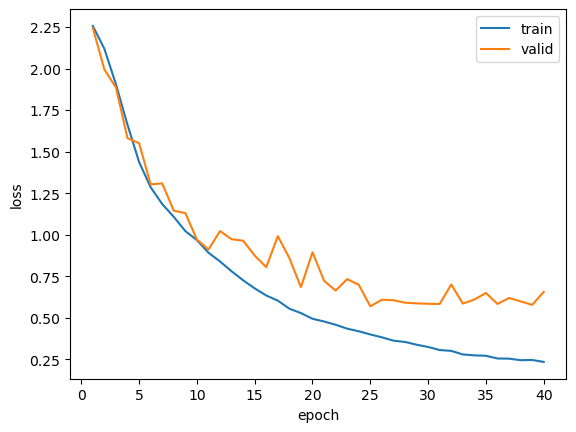

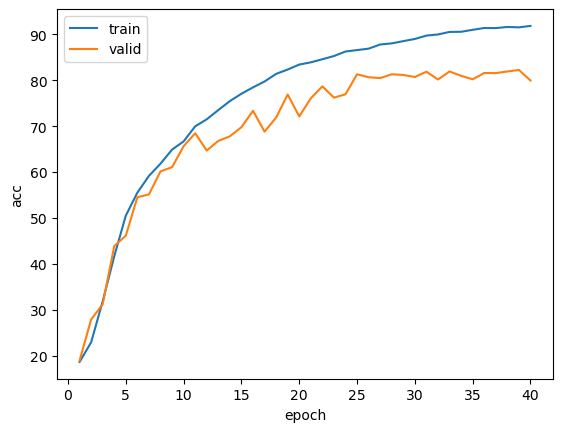

Fold 4
train size: 16751, val size: 4187


262it [00:22, 11.43it/s]
66it [00:05, 11.20it/s]


Epoch:1/40  Training Loss:2.236 || Training Acc 18.494 % ||  valid Loss:2.131 ||  valid Acc 23.461 %


262it [00:22, 11.51it/s]
66it [00:05, 11.04it/s]


Epoch:2/40  Training Loss:1.975 || Training Acc 28.012 % ||  valid Loss:1.879 ||  valid Acc 31.889 %


262it [00:22, 11.57it/s]
66it [00:05, 11.17it/s]


Epoch:3/40  Training Loss:1.644 || Training Acc 42.110 % ||  valid Loss:1.726 ||  valid Acc 39.796 %


262it [00:23, 11.24it/s]
66it [00:05, 11.03it/s]


Epoch:4/40  Training Loss:1.441 || Training Acc 49.773 % ||  valid Loss:1.510 ||  valid Acc 47.064 %


262it [00:22, 11.41it/s]
66it [00:05, 11.01it/s]


Epoch:5/40  Training Loss:1.298 || Training Acc 54.717 % ||  valid Loss:1.374 ||  valid Acc 51.799 %


262it [00:22, 11.46it/s]
66it [00:05, 11.38it/s]


Epoch:6/40  Training Loss:1.187 || Training Acc 58.761 % ||  valid Loss:1.607 ||  valid Acc 53.977 %


262it [00:23, 11.26it/s]
66it [00:06, 10.90it/s]


Epoch:7/40  Training Loss:1.098 || Training Acc 62.279 % ||  valid Loss:1.133 ||  valid Acc 61.435 %


262it [00:22, 11.46it/s]
66it [00:05, 11.41it/s]


Epoch:8/40  Training Loss:1.025 || Training Acc 64.522 % ||  valid Loss:1.050 ||  valid Acc 62.902 %


262it [00:22, 11.47it/s]
66it [00:06, 10.96it/s]


Epoch:9/40  Training Loss:0.957 || Training Acc 66.967 % ||  valid Loss:0.980 ||  valid Acc 66.596 %


262it [00:22, 11.47it/s]
66it [00:05, 11.35it/s]


Epoch:10/40  Training Loss:0.910 || Training Acc 68.762 % ||  valid Loss:1.033 ||  valid Acc 65.625 %


262it [00:22, 11.53it/s]
66it [00:05, 11.45it/s]


Epoch:11/40  Training Loss:0.865 || Training Acc 70.468 % ||  valid Loss:0.927 ||  valid Acc 68.845 %


262it [00:22, 11.40it/s]
66it [00:06, 10.93it/s]


Epoch:12/40  Training Loss:0.810 || Training Acc 72.239 % ||  valid Loss:0.896 ||  valid Acc 69.152 %


262it [00:22, 11.49it/s]
66it [00:05, 11.12it/s]


Epoch:13/40  Training Loss:0.766 || Training Acc 73.766 % ||  valid Loss:0.903 ||  valid Acc 70.431 %


262it [00:22, 11.55it/s]
66it [00:05, 11.25it/s]


Epoch:14/40  Training Loss:0.724 || Training Acc 75.256 % ||  valid Loss:0.859 ||  valid Acc 71.165 %


262it [00:22, 11.51it/s]
66it [00:06, 10.98it/s]


Epoch:15/40  Training Loss:0.684 || Training Acc 77.063 % ||  valid Loss:0.800 ||  valid Acc 72.064 %


262it [00:23, 11.37it/s]
66it [00:06, 10.99it/s]


Epoch:16/40  Training Loss:0.647 || Training Acc 78.256 % ||  valid Loss:0.936 ||  valid Acc 69.792 %


262it [00:22, 11.53it/s]
66it [00:05, 11.37it/s]


Epoch:17/40  Training Loss:0.611 || Training Acc 79.479 % ||  valid Loss:0.813 ||  valid Acc 73.603 %


262it [00:22, 11.45it/s]
66it [00:06, 10.97it/s]


Epoch:18/40  Training Loss:0.590 || Training Acc 80.105 % ||  valid Loss:0.765 ||  valid Acc 74.905 %


262it [00:23, 11.34it/s]
66it [00:06, 10.57it/s]


Epoch:19/40  Training Loss:0.561 || Training Acc 81.065 % ||  valid Loss:0.687 ||  valid Acc 76.515 %


262it [00:22, 11.41it/s]
66it [00:05, 11.11it/s]


Epoch:20/40  Training Loss:0.532 || Training Acc 82.234 % ||  valid Loss:0.843 ||  valid Acc 74.929 %


262it [00:22, 11.39it/s]
66it [00:05, 11.38it/s]


Epoch:21/40  Training Loss:0.512 || Training Acc 82.562 % ||  valid Loss:0.780 ||  valid Acc 74.882 %


262it [00:22, 11.56it/s]
66it [00:05, 11.07it/s]


Epoch:22/40  Training Loss:0.487 || Training Acc 83.898 % ||  valid Loss:0.743 ||  valid Acc 75.213 %


262it [00:22, 11.53it/s]
66it [00:05, 11.40it/s]


Epoch:23/40  Training Loss:0.463 || Training Acc 84.614 % ||  valid Loss:0.672 ||  valid Acc 77.628 %


262it [00:22, 11.40it/s]
66it [00:05, 11.08it/s]


Epoch:24/40  Training Loss:0.440 || Training Acc 85.264 % ||  valid Loss:0.634 ||  valid Acc 79.427 %


262it [00:22, 11.57it/s]
66it [00:06, 10.97it/s]


Epoch:25/40  Training Loss:0.437 || Training Acc 85.329 % ||  valid Loss:0.787 ||  valid Acc 75.971 %


262it [00:22, 11.50it/s]
66it [00:05, 11.21it/s]


Epoch:26/40  Training Loss:0.404 || Training Acc 86.146 % ||  valid Loss:0.701 ||  valid Acc 77.983 %


262it [00:22, 11.56it/s]
66it [00:05, 11.32it/s]


Epoch:27/40  Training Loss:0.412 || Training Acc 86.015 % ||  valid Loss:0.630 ||  valid Acc 79.451 %


262it [00:22, 11.47it/s]
66it [00:05, 11.14it/s]


Epoch:28/40  Training Loss:0.379 || Training Acc 87.417 % ||  valid Loss:0.654 ||  valid Acc 79.261 %


262it [00:22, 11.49it/s]
66it [00:05, 11.07it/s]


Epoch:29/40  Training Loss:0.371 || Training Acc 87.399 % ||  valid Loss:0.608 ||  valid Acc 80.185 %


262it [00:22, 11.44it/s]
66it [00:05, 11.04it/s]


Epoch:30/40  Training Loss:0.359 || Training Acc 87.792 % ||  valid Loss:0.636 ||  valid Acc 79.451 %


262it [00:22, 11.57it/s]
66it [00:05, 11.13it/s]


Epoch:31/40  Training Loss:0.334 || Training Acc 88.693 % ||  valid Loss:0.574 ||  valid Acc 81.558 %


262it [00:22, 11.60it/s]
66it [00:05, 11.12it/s]


Epoch:32/40  Training Loss:0.326 || Training Acc 89.086 % ||  valid Loss:0.535 ||  valid Acc 82.576 %


262it [00:22, 11.41it/s]
66it [00:05, 11.28it/s]


Epoch:33/40  Training Loss:0.316 || Training Acc 89.361 % ||  valid Loss:0.686 ||  valid Acc 78.788 %


262it [00:22, 11.48it/s]
66it [00:05, 11.11it/s]


Epoch:34/40  Training Loss:0.313 || Training Acc 89.361 % ||  valid Loss:0.863 ||  valid Acc 75.379 %


262it [00:22, 11.51it/s]
66it [00:05, 11.29it/s]


Epoch:35/40  Training Loss:0.293 || Training Acc 90.249 % ||  valid Loss:0.910 ||  valid Acc 75.994 %


262it [00:22, 11.52it/s]
66it [00:05, 11.17it/s]


Epoch:36/40  Training Loss:0.292 || Training Acc 90.106 % ||  valid Loss:0.628 ||  valid Acc 80.208 %


262it [00:22, 11.55it/s]
66it [00:05, 11.23it/s]


Epoch:37/40  Training Loss:0.284 || Training Acc 90.178 % ||  valid Loss:0.611 ||  valid Acc 80.777 %


262it [00:22, 11.55it/s]
66it [00:06, 10.92it/s]


Epoch:38/40  Training Loss:0.270 || Training Acc 90.822 % ||  valid Loss:0.673 ||  valid Acc 79.616 %


262it [00:22, 11.41it/s]
66it [00:05, 11.07it/s]


Epoch:39/40  Training Loss:0.261 || Training Acc 91.144 % ||  valid Loss:0.617 ||  valid Acc 81.581 %


262it [00:23, 11.34it/s]
66it [00:05, 11.01it/s]


Epoch:40/40  Training Loss:0.252 || Training Acc 91.281 % ||  valid Loss:0.587 ||  valid Acc 82.102 %
Fold 4
avg train loss: 0.694, avg train acc: 76.026
avg valid loss: 0.910, avg valid acc: 70.099


82it [00:20,  3.98it/s]


Fold 4, test acc: 85.652
plot curves


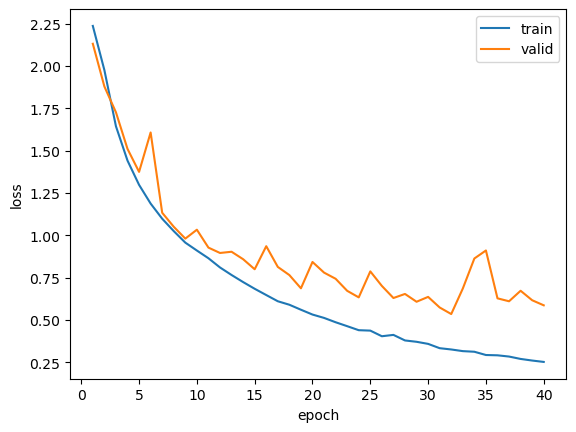

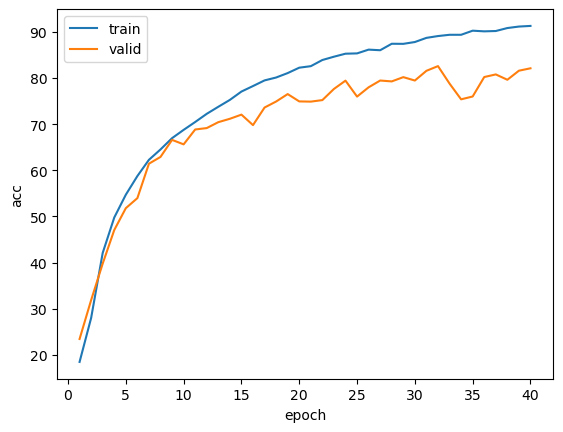

Fold 5
train size: 16751, val size: 4187


262it [00:23, 11.38it/s]
66it [00:06, 10.97it/s]


Epoch:1/40  Training Loss:2.205 || Training Acc 20.986 % ||  valid Loss:2.190 ||  valid Acc 24.550 %


262it [00:22, 11.42it/s]
66it [00:05, 11.22it/s]


Epoch:2/40  Training Loss:1.935 || Training Acc 31.656 % ||  valid Loss:1.748 ||  valid Acc 37.902 %


262it [00:22, 11.57it/s]
66it [00:05, 11.04it/s]


Epoch:3/40  Training Loss:1.593 || Training Acc 45.456 % ||  valid Loss:1.503 ||  valid Acc 47.633 %


262it [00:23, 11.35it/s]
66it [00:05, 11.15it/s]


Epoch:4/40  Training Loss:1.356 || Training Acc 53.089 % ||  valid Loss:1.285 ||  valid Acc 54.309 %


262it [00:22, 11.50it/s]
66it [00:05, 11.27it/s]


Epoch:5/40  Training Loss:1.196 || Training Acc 58.230 % ||  valid Loss:1.233 ||  valid Acc 57.126 %


262it [00:23, 11.36it/s]
66it [00:05, 11.09it/s]


Epoch:6/40  Training Loss:1.094 || Training Acc 61.904 % ||  valid Loss:1.256 ||  valid Acc 56.723 %


262it [00:22, 11.47it/s]
66it [00:05, 11.03it/s]


Epoch:7/40  Training Loss:0.997 || Training Acc 65.703 % ||  valid Loss:1.109 ||  valid Acc 61.742 %


262it [00:22, 11.54it/s]
66it [00:06, 10.95it/s]


Epoch:8/40  Training Loss:0.915 || Training Acc 68.732 % ||  valid Loss:1.014 ||  valid Acc 64.725 %


262it [00:23, 11.32it/s]
66it [00:06, 10.67it/s]


Epoch:9/40  Training Loss:0.847 || Training Acc 71.016 % ||  valid Loss:0.946 ||  valid Acc 67.803 %


262it [00:23, 11.38it/s]
66it [00:05, 11.03it/s]


Epoch:10/40  Training Loss:0.776 || Training Acc 73.682 % ||  valid Loss:0.989 ||  valid Acc 67.424 %


262it [00:22, 11.48it/s]
66it [00:05, 11.11it/s]


Epoch:11/40  Training Loss:0.714 || Training Acc 75.775 % ||  valid Loss:0.854 ||  valid Acc 70.573 %


262it [00:22, 11.45it/s]
66it [00:05, 11.17it/s]


Epoch:12/40  Training Loss:0.664 || Training Acc 77.660 % ||  valid Loss:0.809 ||  valid Acc 71.851 %


262it [00:22, 11.47it/s]
66it [00:06, 10.89it/s]


Epoch:13/40  Training Loss:0.622 || Training Acc 79.127 % ||  valid Loss:0.725 ||  valid Acc 75.497 %


262it [00:22, 11.58it/s]
66it [00:06, 10.62it/s]


Epoch:14/40  Training Loss:0.586 || Training Acc 80.415 % ||  valid Loss:0.725 ||  valid Acc 76.042 %


262it [00:22, 11.61it/s]
66it [00:06, 10.92it/s]


Epoch:15/40  Training Loss:0.541 || Training Acc 81.906 % ||  valid Loss:0.741 ||  valid Acc 75.568 %


262it [00:22, 11.49it/s]
66it [00:06, 10.74it/s]


Epoch:16/40  Training Loss:0.514 || Training Acc 82.920 % ||  valid Loss:0.624 ||  valid Acc 78.906 %


262it [00:22, 11.58it/s]
66it [00:06, 10.96it/s]


Epoch:17/40  Training Loss:0.485 || Training Acc 83.594 % ||  valid Loss:0.632 ||  valid Acc 78.930 %


262it [00:22, 11.43it/s]
66it [00:06, 10.70it/s]


Epoch:18/40  Training Loss:0.457 || Training Acc 84.500 % ||  valid Loss:0.590 ||  valid Acc 80.350 %


262it [00:22, 11.42it/s]
66it [00:05, 11.07it/s]


Epoch:19/40  Training Loss:0.434 || Training Acc 85.443 % ||  valid Loss:0.600 ||  valid Acc 79.522 %


262it [00:22, 11.44it/s]
66it [00:05, 11.07it/s]


Epoch:20/40  Training Loss:0.411 || Training Acc 86.242 % ||  valid Loss:0.563 ||  valid Acc 80.990 %


262it [00:22, 11.47it/s]
66it [00:06, 10.91it/s]


Epoch:21/40  Training Loss:0.385 || Training Acc 86.743 % ||  valid Loss:0.583 ||  valid Acc 80.919 %


262it [00:22, 11.44it/s]
66it [00:06, 10.97it/s]


Epoch:22/40  Training Loss:0.378 || Training Acc 87.077 % ||  valid Loss:0.606 ||  valid Acc 80.611 %


262it [00:22, 11.45it/s]
66it [00:06, 10.96it/s]


Epoch:23/40  Training Loss:0.353 || Training Acc 88.114 % ||  valid Loss:0.572 ||  valid Acc 81.061 %


262it [00:22, 11.55it/s]
66it [00:06, 10.78it/s]


Epoch:24/40  Training Loss:0.347 || Training Acc 88.299 % ||  valid Loss:0.567 ||  valid Acc 81.321 %


262it [00:23, 11.28it/s]
66it [00:06, 10.88it/s]


Epoch:25/40  Training Loss:0.319 || Training Acc 89.206 % ||  valid Loss:0.590 ||  valid Acc 80.871 %


262it [00:22, 11.44it/s]
66it [00:05, 11.01it/s]


Epoch:26/40  Training Loss:0.317 || Training Acc 89.480 % ||  valid Loss:0.516 ||  valid Acc 82.528 %


262it [00:22, 11.51it/s]
66it [00:06, 10.97it/s]


Epoch:27/40  Training Loss:0.295 || Training Acc 90.148 % ||  valid Loss:0.518 ||  valid Acc 83.191 %


262it [00:22, 11.46it/s]
66it [00:05, 11.06it/s]


Epoch:28/40  Training Loss:0.295 || Training Acc 89.969 % ||  valid Loss:0.638 ||  valid Acc 80.469 %


262it [00:23, 11.37it/s]
66it [00:05, 11.14it/s]


Epoch:29/40  Training Loss:0.291 || Training Acc 90.100 % ||  valid Loss:0.622 ||  valid Acc 80.208 %


262it [00:22, 11.48it/s]
66it [00:05, 11.19it/s]


Epoch:30/40  Training Loss:0.273 || Training Acc 90.714 % ||  valid Loss:0.593 ||  valid Acc 80.327 %


262it [00:23, 11.38it/s]
66it [00:05, 11.12it/s]


Epoch:31/40  Training Loss:0.255 || Training Acc 91.233 % ||  valid Loss:0.564 ||  valid Acc 81.416 %


262it [00:22, 11.56it/s]
66it [00:06, 10.91it/s]


Epoch:32/40  Training Loss:0.250 || Training Acc 91.657 % ||  valid Loss:0.575 ||  valid Acc 82.102 %


262it [00:22, 11.50it/s]
66it [00:05, 11.14it/s]


Epoch:33/40  Training Loss:0.232 || Training Acc 92.116 % ||  valid Loss:0.590 ||  valid Acc 82.079 %


262it [00:22, 11.43it/s]
66it [00:06, 10.94it/s]


Epoch:34/40  Training Loss:0.242 || Training Acc 91.651 % ||  valid Loss:0.569 ||  valid Acc 82.363 %


262it [00:22, 11.47it/s]
66it [00:06, 10.95it/s]


Epoch:35/40  Training Loss:0.217 || Training Acc 92.325 % ||  valid Loss:0.607 ||  valid Acc 81.629 %


262it [00:22, 11.47it/s]
66it [00:05, 11.03it/s]


Epoch:36/40  Training Loss:0.225 || Training Acc 92.265 % ||  valid Loss:0.574 ||  valid Acc 81.795 %


262it [00:22, 11.48it/s]
66it [00:05, 11.02it/s]


Epoch:37/40  Training Loss:0.208 || Training Acc 92.826 % ||  valid Loss:0.535 ||  valid Acc 83.523 %


262it [00:22, 11.43it/s]
66it [00:05, 11.20it/s]


Epoch:38/40  Training Loss:0.198 || Training Acc 93.339 % ||  valid Loss:0.577 ||  valid Acc 82.931 %


262it [00:22, 11.45it/s]
66it [00:06, 10.73it/s]


Epoch:39/40  Training Loss:0.198 || Training Acc 93.225 % ||  valid Loss:0.517 ||  valid Acc 84.351 %


262it [00:22, 11.42it/s]
66it [00:05, 11.01it/s]


Epoch:40/40  Training Loss:0.194 || Training Acc 93.452 % ||  valid Loss:0.596 ||  valid Acc 82.647 %
Fold 5
avg train loss: 0.595, avg train acc: 79.549
avg valid loss: 0.791, avg valid acc: 73.613


82it [00:20,  3.96it/s]


Fold 5, test acc: 85.671
plot curves


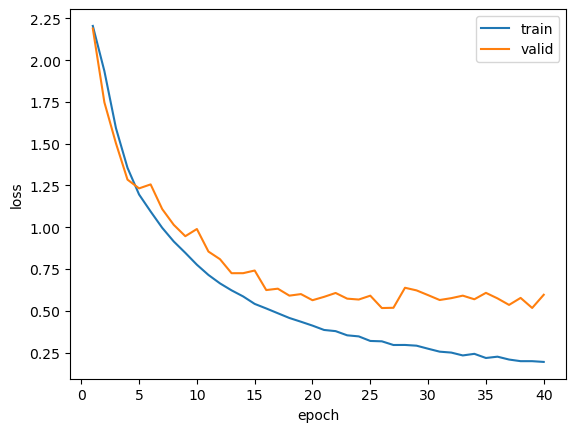

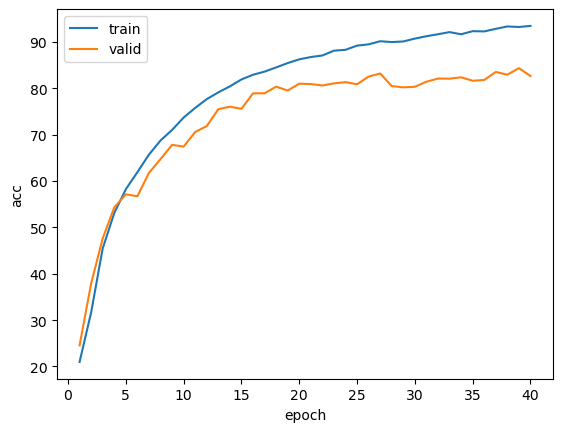

In [19]:
from torch.utils.data import sampler
K = 5
# learning_rate=0.001


kfold = KFold(n_splits=K,shuffle=True)

train_fold_losses = []
train_fold_accs = []
valid_fold_losses = []
valid_fold_accs = []

for fold_i, (train_ids, val_ids) in enumerate(kfold.split(train_data)):
    print(f'Fold {fold_i+1}')
    print(f'train size: {len(train_ids)}, val size: {len(val_ids)}')
    print('='*50)
    fold_train_loss,fold_valid_loss,fold_train_acc,fold_valid_acc=[],[],[],[]
    # Reset model parameters
    # model.load_state_dict(torch.load(PATH))
    model.apply(weight_reset)
    # Sample elements from selected ids
    train_sampler = sampler.SubsetRandomSampler(train_ids)
    val_sampler = sampler.SubsetRandomSampler(val_ids)

    #Use sampler to select data for training and validation
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
                                               sampler=train_sampler,num_workers=2)
    val_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
                                             sampler=val_sampler,num_workers=2)
    
    #optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    # Training
    for epoch in range(num_epochs):
        train_loss, train_acc = train(train_loader, model, criterion, optimizer)
        val_loss, val_acc = test(val_loader, model, criterion)
        fold_train_loss.append(train_loss)
        fold_valid_loss.append(val_loss)
        fold_train_acc.append(train_acc)
        fold_valid_acc.append(val_acc)
        # if epoch%10==0:
        print("Epoch:{}/{}  Training Loss:{:.3f} || Training Acc {:.3f} % ||  valid Loss:{:.3f} ||  valid Acc {:.3f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             train_acc,                            
                                                                                                             val_loss,
                                                                                                             val_acc))
    
    
    print(f'Fold {fold_i+1}')
    print(f'avg train loss: {sum(fold_train_loss)/num_epochs:.3f}, avg train acc: {sum(fold_train_acc)/num_epochs:.3f}')
    print(f'avg valid loss: {sum(fold_valid_loss)/num_epochs:.3f}, avg valid acc: {sum(fold_valid_acc)/num_epochs:.3f}')
    torch.save(model,'fold'+str(fold_i+1)+'.pt')
    torch.save(model.state_dict(), 'fold'+str(fold_i+1)+'.pth')
    print('='*100)
    test_loss, test_acc = test(testloader, model, criterion)
    
    print(f'Fold {fold_i+1}, test acc: {test_acc:.3f}')
    print('='*50)
    train_fold_losses.append(sum(fold_train_loss)/num_epochs)
    train_fold_accs.append(sum(fold_train_acc)/num_epochs)
    valid_fold_losses.append(sum(fold_valid_loss)/num_epochs)
    valid_fold_accs.append(sum(fold_valid_acc)/num_epochs)
    
    # print(f'fold_train_loss:{fold_train_loss}')
    # print(f'fold_valid_loss:{fold_valid_loss}')
    print ("plot curves")
    plotCurve(range(1, num_epochs + 1), fold_train_loss,
              "epoch", "loss",
              range(1, num_epochs + 1), fold_valid_loss,
              ["train", "valid"]
             )
    plotCurve(range(1, num_epochs + 1), fold_train_acc,
              "epoch", "acc",
              range(1, num_epochs + 1), fold_valid_acc,
              ["train", "valid"]
             )
    


In [28]:
print(f'fold_avg_train_loss: {sum(train_fold_losses)/5:5.2f}')
print(f'fold_avg_train_acc:  {sum(train_fold_accs)/K:5.2f} %')
print(f'fold_avg_valid_loss: {sum(valid_fold_losses)/K:5.2f}')
print(f'fold_avg_valid_acc:  {sum(valid_fold_accs)/K:5.2f} %')

fold_avg_train_loss:  0.67
fold_avg_train_acc:  77.05 %
fold_avg_valid_loss:  0.89
fold_avg_valid_acc:  70.63 %


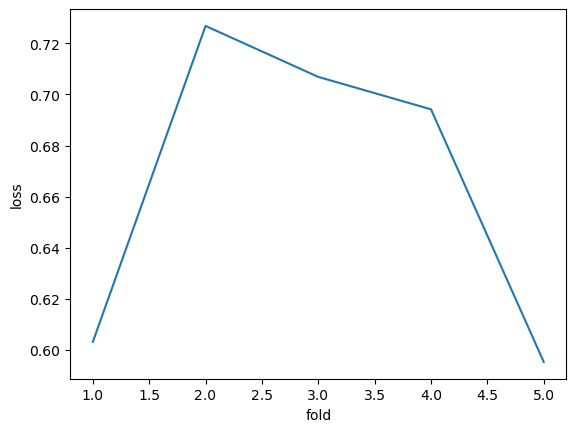

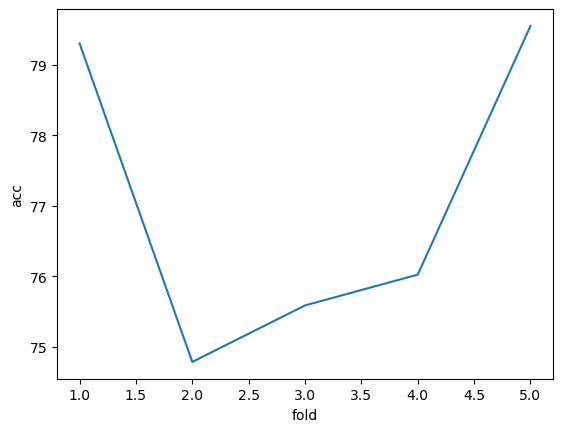

In [29]:
plotCurve((1,2,3,4,5), train_fold_losses,
              "fold", "loss",
             )
plotCurve(range(1, K + 1), train_fold_accs,
              "fold", "acc",
             )

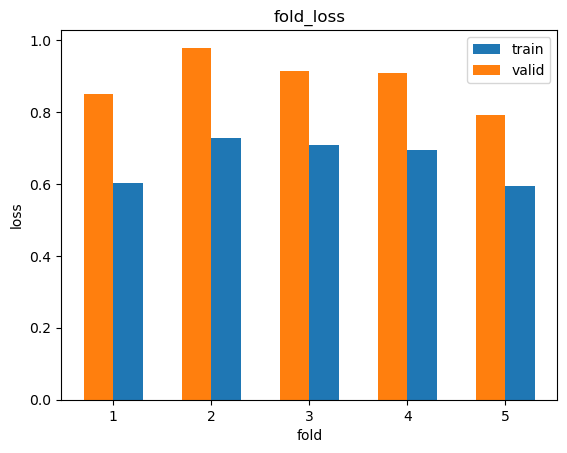

In [30]:
plt.bar(range(1, K + 1), train_fold_losses,width=0.3, align='edge')
plt.bar(range(1, K + 1), valid_fold_losses,width=-0.3, align='edge')
plt.title('fold_loss')
plt.xlabel('fold')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.xticks(ticks=range(1, K + 1),
          labels=['1','2','3','4','5'],
          )
plt.show()

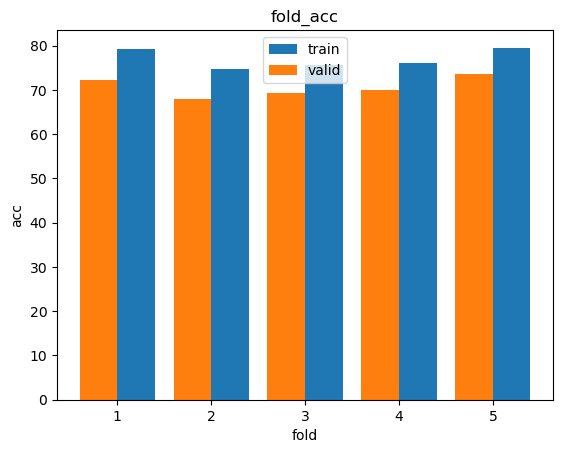

In [31]:
plt.bar(range(1, K + 1), train_fold_accs,width=0.4, align='edge')
plt.bar(range(1, K + 1), valid_fold_accs,width=-0.4,align='edge')
plt.title('fold_acc')
plt.xlabel('fold')
plt.ylabel('acc')
plt.legend(['train','valid'])
plt.xticks(ticks=range(1, K + 1),
          labels=['1','2','3','4','5'],
          )
plt.show()

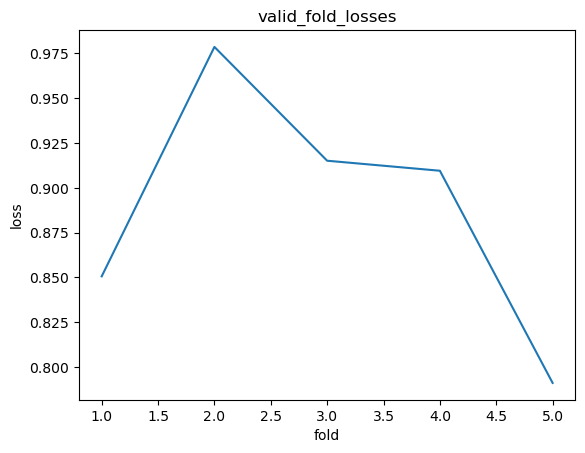

In [32]:
plt.plot(range(1, K + 1), valid_fold_losses)
plt.title('valid_fold_losses')
plt.xlabel('fold')
plt.ylabel('loss')
plt.show()

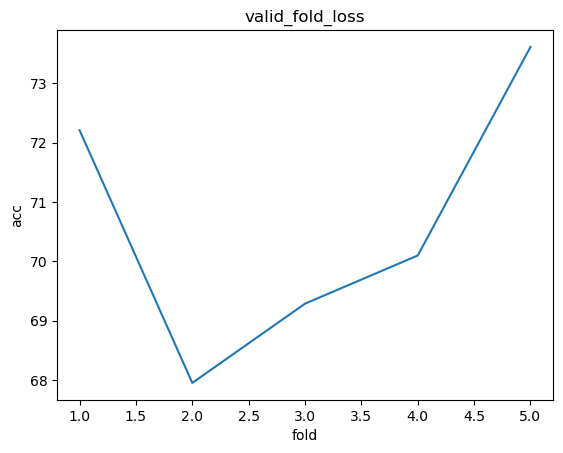

In [33]:
plt.plot(range(1, K + 1), valid_fold_accs)
plt.title('valid_fold_loss')
plt.xlabel('fold')
plt.ylabel('acc')
plt.show()

In [35]:
print('train')
print(sum(train_fold_losses)/len(train_fold_losses))
print(sum(train_fold_accs)/len(train_fold_accs))
print('='*100)
print('valid')
print(sum(valid_fold_losses)/len(valid_fold_losses))
print(sum(valid_fold_accs)/len(valid_fold_accs))

train
0.6652594345966568
77.0514074427481
valid
0.88900525002317
70.63245738636364


In [27]:
plt.bar(range(1, K + 1), fold_accs)
plt.xlabel('fold')
plt.ylabel('acc')
plt.show()

NameError: name 'fold_accs' is not defined

In [ ]:
# for epoch in range(num_epochs):
#     train_loss = 0.0
#     train_acc = 0.0
#     valid_loss=0.0
#     valid_acc=0.0
#     model = model.train()

#     ## training step
#     for i, (images, labels) in enumerate(trainloader):
        
#         images = images.to(device)
#         labels = labels.to(device)

#         ## forward + backprop + loss
#         logits = model(images)
#         loss = criterion(logits, labels)
#         optimizer.zero_grad()
#         loss.backward()

#         ## update model params
#         optimizer.step()

#         train_loss += loss.detach().item()
#         train_acc += get_accuracy(logits, labels, BATCH_SIZE)
#     model.eval()
#     for j,(data, labels) in enumerate(validloader):
#         # move tensors to GPU if CUDA is available
#         data, labels = data.to(device), labels.to(device)
#         # forward pass: compute predicted outputs by passing inputs to the model
#         output = model(data)
#         # calculate the batch loss
#         loss = criterion(output, labels)
#         # update average validation loss 
#         valid_loss += loss.item()
#         valid_acc += get_accuracy(output, labels, BATCH_SIZE)
#     model.eval()
#     print('Epoch: %d | Loss: %.4f | Train Accuracy: %.4f  | valid_Loss: %.4f | valid Accuracy: %.4f     ' \
#           %(epoch, train_loss / i, train_acc/i,  valid_loss / j, valid_acc/j))        

In [39]:
model = torch.load('fold2.pt')
# model.load_state_dict(torch.load('fold1.pth'))  
model.eval()
test_loss, test_acc = test(testloader, model, criterion)
print(f'Fold, test acc: {test_acc:.3f}')

82it [00:20,  3.95it/s]

Fold, test acc: 83.594


In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))